In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from scipy import stats
from adjustText import adjust_text
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
import gseapy as gp #this method requires internet connection

In [2]:
adata = sc.read('annotated.h5ad')
adata.obs

,samples,condition,location,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,low_label,low_score,_scvi_batch,_scvi_labels,overcluster,low_major,Cell_Type
711_AAACCCAAGTCGGGAT-1,711,Tumor,Right,707,707,6.562444,1396.0,7.242083,26.862464,10.100286,25.716331,0.000000,T follicular helper cells,0.103311,0,0,14,CD4+ T cells,CD4+ T Cells
711_AAACCCACAGAGGAAA-1,711,Tumor,Right,838,838,6.732211,1504.0,7.316548,23.803191,9.441490,13.962767,0.000000,Unknown,0.236022,0,0,11,CD4+ T cells,CD4+ T Cells
711_AAACCCACATGATAGA-1,711,Tumor,Right,435,435,6.077642,613.0,6.419995,17.781403,0.815661,18.270800,0.000000,Unknown,0.400460,0,0,36,CMS3,CMS3
711_AAACCCAGTCTCGCGA-1,711,Tumor,Right,579,579,6.363028,860.0,6.758094,23.255814,15.465117,6.395349,0.000000,Tip-like ECs,0.966648,0,0,28,Tip-like ECs,Tip-like ECs
711_AAACGAAGTTATCTTC-1,711,Tumor,Right,1384,1384,7.233455,2629.0,7.874739,19.246862,8.178015,15.405098,0.000000,gamma delta T cells,0.993837,0,0,15,CD8+ T cells,CD8+ T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706_TTTGGTTCAAACACCT-1,706,Tumor,Left,1815,1815,7.504392,4944.0,8.506132,21.318770,1.961974,21.318771,0.020227,CD8+ T cells,0.999997,0,0,1,CD8+ T cells,CD8+ T cells
706_TTTGGTTCAACGGGTA-1,706,Tumor,Left,909,909,6.813445,3528.0,8.168770,34.722222,0.368481,25.368483,0.000000,Pro-inflammatory,0.549964,0,0,12,SPP1+,Spp1+
706_TTTGGTTTCTATCGCC-1,706,Tumor,Left,4658,4658,8.446556,23600.0,10.069044,17.559322,3.237288,18.135593,0.004237,Stromal 2,0.961222,0,0,25,Stromal 2,Stromal 2
706_TTTGTTGCATCAGCGC-1,706,Tumor,Left,374,374,5.926926,686.0,6.532334,23.032070,10.932944,33.236153,0.000000,CMS2,0.978673,0,0,10,CMS2,CMS2


In [3]:
model = scvi.model.SCVI.load('the_model/', adata)
model

INFO     File the_model/model.pt already downloaded                                                                


SCVI model with the following parameters: 
n_hidden: 256, n_latent: 60, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [4]:
#any set of cells vs any set of cells
scvi_de = model.differential_expression(
     idx1 = [(adata.obs['Cell_Type'].isin(['CMS2'])) & (adata.obs.condition == 'Tumor')],
     idx2 = [(adata.obs['Cell_Type'].isin(['CMS3'])) & (adata.obs.condition == 'Tumor')],
     mode='change',
    pseudocounts=1e-7,
    test_mode='two'
     )

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
AC007952.4,0.9756,0.0244,3.688469,5.147574e-06,0.000287,1.000000e-07,0.25,-6.390139,-6.485783,6.123112,-20.451763,14.319461,0.008489,0.264436,0.019875,0.194962,0.070535,2.939790,True
LINC01285,0.9774,0.0226,3.766946,1.689434e-06,0.000061,1.000000e-07,0.25,-5.120412,-5.152416,4.219293,-19.002392,8.167394,0.004082,0.091376,0.012493,0.075569,0.032602,0.992484,True
HIST2H3D,0.9790,0.0210,3.842009,1.300212e-06,0.000036,1.000000e-07,0.25,-4.973235,-5.125866,4.070366,-15.867760,8.304714,0.002032,0.073676,0.005679,0.068668,0.016306,0.818914,True
NPIPB4,0.9816,0.0184,3.976833,1.144900e-06,0.000041,1.000000e-07,0.25,-4.849019,-4.919121,2.855093,-14.344093,5.152382,0.002000,0.059959,0.010789,0.065562,0.015530,0.620076,True
HDAC11-AS1,0.9532,0.0468,3.013941,2.954144e-07,0.000009,1.000000e-07,0.25,-4.791900,-5.128112,3.655943,-13.405945,7.633379,0.000653,0.016496,0.001136,0.016218,0.004898,0.182052,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAMP2,0.9494,0.0506,2.931878,7.886726e-06,0.000002,1.000000e-07,0.25,2.544311,2.578904,2.610689,-10.077436,11.561687,0.013131,0.001463,0.034639,0.003106,0.130214,0.016527,True
NDUFC2,0.9588,0.0412,3.147244,1.292572e-04,0.000049,1.000000e-07,0.25,2.565709,2.645349,3.339342,-6.397724,11.229609,0.175409,0.077743,0.224872,0.134231,1.787161,0.652754,True
RBP2,0.9500,0.0500,2.944439,1.143473e-05,0.000002,1.000000e-07,0.25,2.750833,2.533058,2.937353,-7.644653,13.385956,0.016995,0.005193,0.045429,0.009317,0.165932,0.058852,True
C3orf14,0.9556,0.0444,3.069100,9.579128e-06,0.000002,1.000000e-07,0.25,2.909056,3.042600,2.546017,-6.591202,10.405578,0.013365,0.001543,0.046564,0.004141,0.117675,0.013739,True


In [15]:
scvi_de2=scvi_de.copy()
scvi_de2 = scvi_de2[(scvi_de2.raw_normalized_mean1 > .5) | (scvi_de2.raw_normalized_mean2 > .5)]
scvi_de2

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_bf
AC007952.4,0.9756,0.0244,3.688469,0.000005,0.000287,1.000000e-07,0.25,-6.390139,-6.485783,6.123112,-20.451763,14.319461,0.008489,0.264436,0.019875,0.194962,0.070535,2.939790,True,0.566846
LINC01285,0.9774,0.0226,3.766946,0.000002,0.000061,1.000000e-07,0.25,-5.120412,-5.152416,4.219293,-19.002392,8.167394,0.004082,0.091376,0.012493,0.075569,0.032602,0.992484,True,0.575989
HIST2H3D,0.9790,0.0210,3.842009,0.000001,0.000036,1.000000e-07,0.25,-4.973235,-5.125866,4.070366,-15.867760,8.304714,0.002032,0.073676,0.005679,0.068668,0.016306,0.818914,True,0.584558
NPIPB4,0.9816,0.0184,3.976833,0.000001,0.000041,1.000000e-07,0.25,-4.849019,-4.919121,2.855093,-14.344093,5.152382,0.002000,0.059959,0.010789,0.065562,0.015530,0.620076,True,0.599537
HIST1H2BB,0.9704,0.0296,3.489934,0.000001,0.000065,1.000000e-07,0.25,-4.634457,-5.116297,3.626644,-14.463923,8.291567,0.002506,0.132782,0.006814,0.114907,0.021986,1.450713,True,0.542817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFN2,0.9480,0.0520,2.903111,0.000039,0.000009,1.000000e-07,0.25,2.377000,2.461073,2.470800,-6.318192,10.138033,0.061183,0.010036,0.130608,0.017598,0.558565,0.097651,True,0.462864
COPRS,0.9474,0.0526,2.891005,0.000052,0.000015,1.000000e-07,0.25,2.429323,2.245384,2.138174,-4.443795,9.582110,0.096561,0.022532,0.207836,0.073154,0.904486,0.196555,True,0.461049
TOMM22,0.9604,0.0396,3.188521,0.000183,0.000045,1.000000e-07,0.25,2.460608,2.450954,1.580730,-2.430678,7.246021,0.268031,0.066395,0.403180,0.151484,2.491774,0.565405,True,0.503589
RBP1,0.9484,0.0516,2.911254,0.000030,0.000006,1.000000e-07,0.25,2.461429,2.410064,3.238621,-7.728210,12.525037,0.074083,0.012777,0.089154,0.020014,0.661149,0.117989,True,0.464080


In [16]:
genes_to_show = scvi_de2[-25:].index.tolist() + scvi_de2[:25].index.tolist() #top 25 and bottom 25 from sorted df
genes_to_show

['ESD',
 'C12orf75',
 'VBP1',
 'RPS10',
 'CDK2AP1',
 'NDUFB5',
 'PRDX3',
 'NME1',
 'EIF3E',
 'SLC25A5',
 'NDUFAB1',
 'POMP',
 'CDKN3',
 'FKBP1A',
 'SUMO2',
 'TDGF1',
 'LDHB',
 'GCSH',
 'TMEM126A',
 'GGH',
 'PFN2',
 'COPRS',
 'TOMM22',
 'RBP1',
 'NDUFC2',
 'AC007952.4',
 'LINC01285',
 'HIST2H3D',
 'NPIPB4',
 'HIST1H2BB',
 'TNFRSF10D',
 'NEAT1',
 'MALAT1',
 'MTRNR2L8',
 'HIST1H4B',
 'UVSSA',
 'ANGPTL4',
 'HIST1H3J',
 'TNFSF9',
 'C1RL-AS1',
 'HIST1H3A',
 'GOLGA8B',
 'NPIPB5',
 'HIST1H2BG',
 'MUC17',
 'TBX20',
 'KCNQ1OT1',
 'CHRNA7',
 'XIST',
 'ERN2']

In [14]:
# Subset to CMS2 and CMS3 tumor cells only
adata_cms_tumor = adata[
    (adata.obs['condition'] == 'Tumor') & 
    (adata.obs['Cell_Type'].isin(['CMS2', 'CMS3']))
].copy()

# Verify the subset
print(f"Total cells: {adata_cms_tumor.shape[0]}")
print(f"CMS2 cells: {(adata_cms_tumor.obs['Cell_Type'] == 'CMS2').sum()}")
print(f"CMS3 cells: {(adata_cms_tumor.obs['Cell_Type'] == 'CMS3').sum()}")
print(f"Cell types present: {adata_cms_tumor.obs['Cell_Type'].unique()}")
print(f"Conditions present: {adata_cms_tumor.obs['condition'].unique()}")

Total cells: 4659
CMS2 cells: 1761
CMS3 cells: 2898
Cell types present: ['CMS3', 'CMS2']
Categories (2, object): ['CMS2', 'CMS3']
Conditions present: ['Tumor']
Categories (1, object): ['Tumor']


In [ ]:
subset = (adata[adata.obs['Cell_Type'].isin(['CMS2','CMS3'])] & (adata.obs['condition'] == 'Tumor') ).copy()
subset

In [20]:
adata.layers

Layers with keys: counts

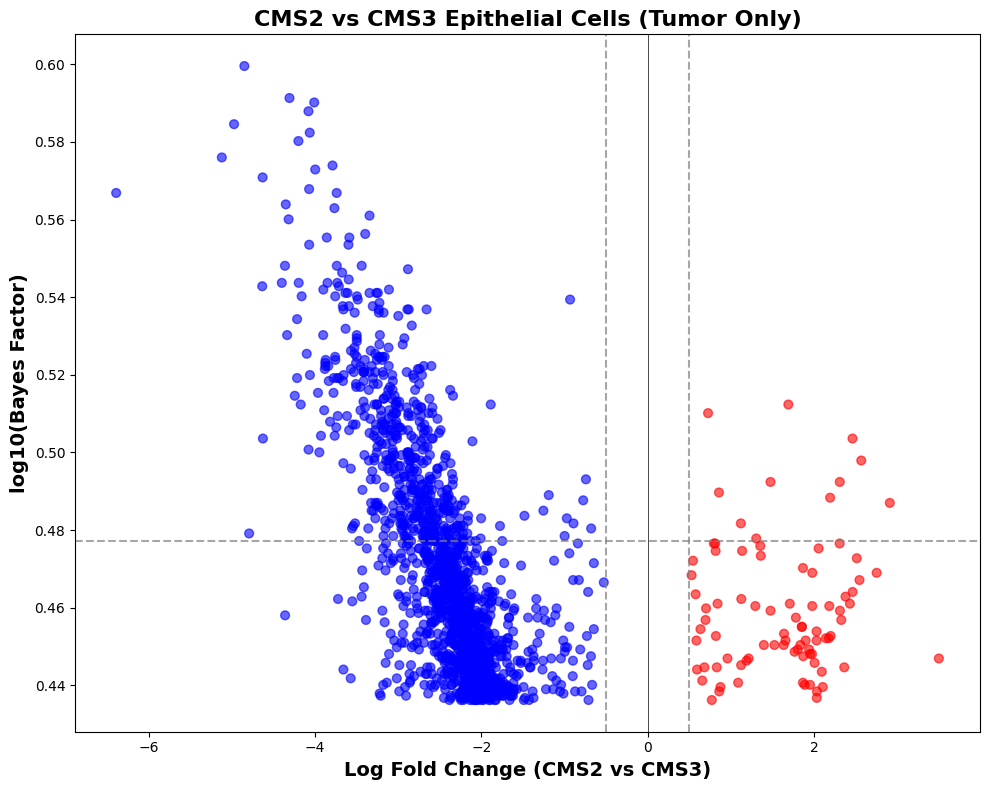

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
scvi_de['log10_bf'] = np.log10(scvi_de['bayes_factor'] + 1e-10)

colors = ['red' if x > 0 else 'blue' for x in scvi_de['lfc_mean']]

ax.scatter(scvi_de['lfc_mean'], scvi_de['log10_bf'],
           c=colors, alpha=0.6, s=40)

ax.axhline(y=np.log10(3), color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.7)

ax.set_xlabel('Log Fold Change (CMS2 vs CMS3)', fontsize=14, fontweight='bold')
ax.set_ylabel('log10(Bayes Factor)', fontsize=14, fontweight='bold')
ax.set_title('CMS2 vs CMS3 Epithelial Cells (Tumor Only)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('volcano_CMS2_vs_CMS3_tumor.png', dpi=300, bbox_inches='tight')
plt.show()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


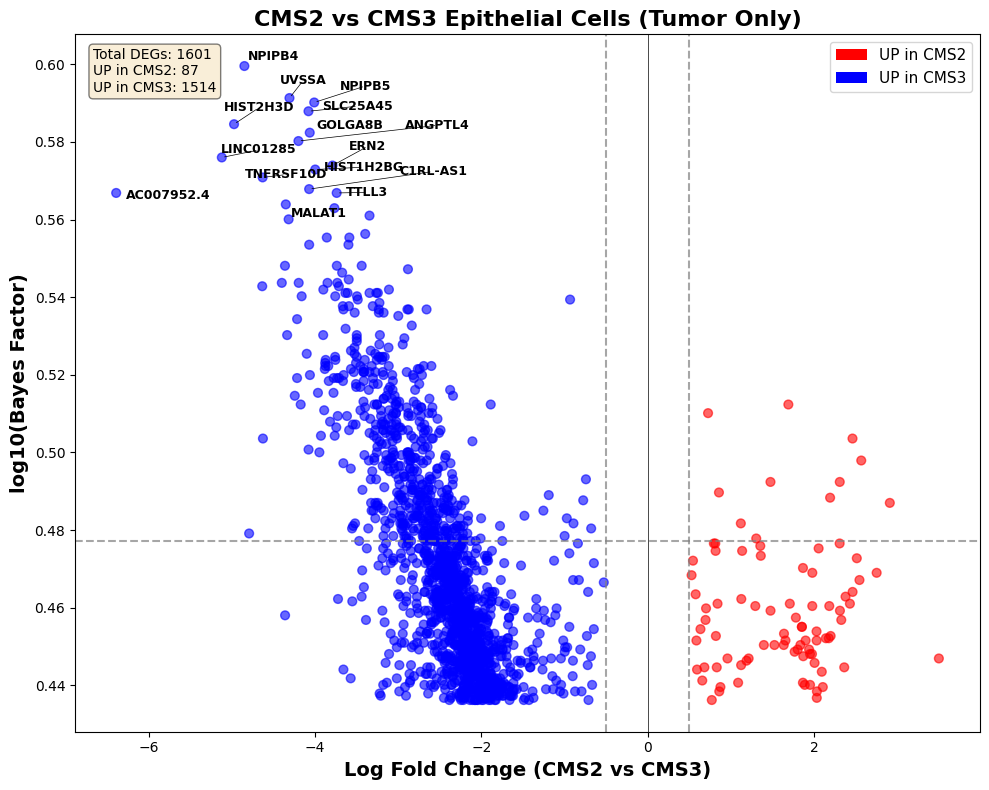

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
scvi_de['log10_bf'] = np.log10(scvi_de['bayes_factor'] + 1e-10)
colors = ['red' if x > 0 else 'blue' for x in scvi_de['lfc_mean']]

ax.scatter(scvi_de['lfc_mean'], scvi_de['log10_bf'],
           c=colors, alpha=0.6, s=40)

# Label top genes
texts = []
top_genes = scvi_de.nlargest(15, 'log10_bf')  # Top 15 by Bayes factor

for gene_name, gene in top_genes.iterrows():
    texts.append(
        ax.text(
            gene['lfc_mean'],
            gene['log10_bf'],
            gene_name,
            fontsize=9,
            fontweight='bold'
        )
    )

# Adjust text to avoid overlaps
try:
    from adjustText import adjust_text
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
        expand_points=(1.5, 1.5),
        force_points=(0.5, 0.5)
    )
except ImportError:
    print("Install adjustText: pip install adjustText")

ax.axhline(y=np.log10(3), color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.7)

ax.set_xlabel('Log Fold Change (CMS2 vs CMS3)', fontsize=14, fontweight='bold')
ax.set_ylabel('log10(Bayes Factor)', fontsize=14, fontweight='bold')
ax.set_title('CMS2 vs CMS3 Epithelial Cells (Tumor Only)', fontsize=16, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='UP in CMS2'),
    Patch(facecolor='blue', label='UP in CMS3'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=True)

# Add summary stats box
n_up_cms2 = (scvi_de['lfc_mean'] > 0).sum()
n_up_cms3 = (scvi_de['lfc_mean'] < 0).sum()
n_total = len(scvi_de)

textstr = f'Total DEGs: {n_total}\nUP in CMS2: {n_up_cms2}\nUP in CMS3: {n_up_cms3}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('volcano_CMS2_vs_CMS3_tumor.png', dpi=300, bbox_inches='tight')
plt.show()

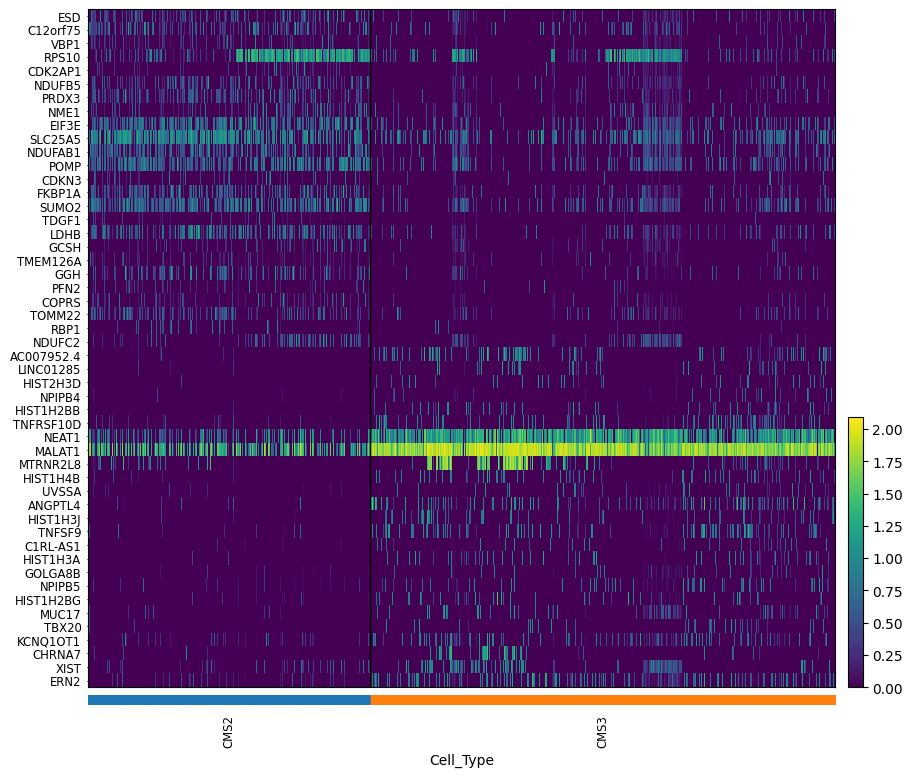

In [17]:

sc.pl.heatmap(adata_cms_tumor, genes_to_show, groupby='Cell_Type', swap_axes=True, 
              log = True)

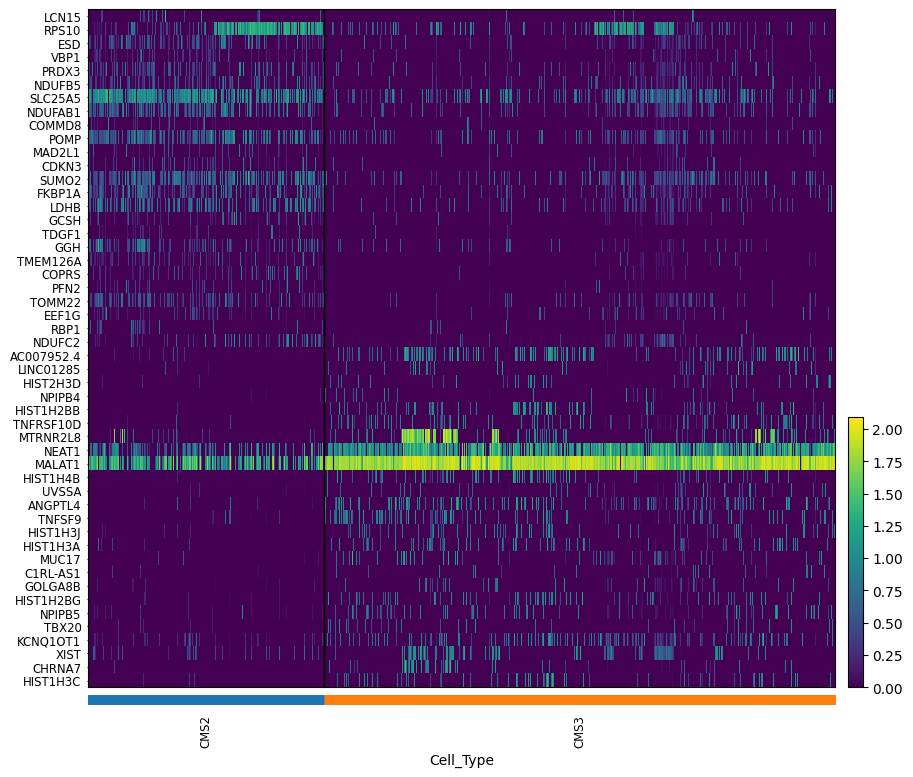

In [17]:
sc.pl.heatmap(subset, genes_to_show, groupby='Cell_Type', swap_axes=True, 
              log = True)

In [23]:
filename = "DEG_CMS2_vs_CMS3.csv"
scvi_de.to_csv(filename)
print(f"Saved: {filename}")

Saved: DEG_CMS2_vs_CMS3.csv


In [11]:
up = scvi_de[scvi_de['lfc_mean'] > 0]
up = up.sort_values('lfc_mean')
up= up.index.tolist()
up

['TMEM238',
 'L1TD1',
 'IGHG2',
 'GZMB',
 'STOM',
 'CXCL8',
 'PARL',
 'IGHA2',
 'PTPRO',
 'ADH1C',
 'OLFM4',
 'LINC01612',
 'PCP4',
 'IGHG1',
 'IGHG3',
 'JCHAIN',
 'PTGDS',
 'IGHM',
 'MMP7',
 'G0S2',
 'LRRC75A',
 'SPP1',
 'RBP4',
 'IGLC2',
 'KLK6',
 'CCL15',
 'KRT23',
 'IGHA1',
 'PCSK1N',
 'FABP2',
 'PLA2G2A',
 'IGKC',
 'IGLC3',
 'TMEM158',
 'RPS4Y1',
 'GNG4',
 'F8A1',
 'PPA1',
 'FABP1',
 'FCER1G',
 'LCN15',
 'RAN',
 'NPM1',
 'SPATC1L',
 'ABRACL',
 'ALG1L',
 'CETN2',
 'NRN1',
 'COX7A2L',
 'S100A4',
 'ESD',
 'C12orf75',
 'VBP1',
 'RPS10',
 'SFTA2',
 'UBD',
 'CDK2AP1',
 'NDUFB5',
 'PRDX3',
 'PBK',
 'GAL',
 'NME1',
 'EIF3E',
 'NAPA-AS1',
 'SLC25A5',
 'NDUFAB1',
 'B4GALT1-AS1',
 'POMP',
 'CDKN3',
 'KCTD6',
 'FKBP1A',
 'SUMO2',
 'TDGF1',
 'LDHB',
 'GCSH',
 'TMEM126A',
 'GGH',
 'PFN2',
 'COPRS',
 'TOMM22',
 'RBP1',
 'CKMT2',
 'RAMP2',
 'NDUFC2',
 'RBP2',
 'C3orf14',
 'AP003774.1']

In [13]:
down = scvi_de[scvi_de['lfc_mean'] < 0]
down = down.sort_values('lfc_mean')
down= down.index.tolist()
down

['AC007952.4',
 'LINC01285',
 'HIST2H3D',
 'NPIPB4',
 'HDAC11-AS1',
 'HIST1H2BB',
 'TNFRSF10D',
 'PRMT5-AS1',
 'PATL2',
 'NEAT1',
 'AL645728.1',
 'MALAT1',
 'MTRNR2L8',
 'HIST1H4B',
 'UVSSA',
 'UXT-AS1',
 'ACER2',
 'TNNT2',
 'ANGPTL4',
 'SNHG22',
 'DUOX1',
 'HIST1H3J',
 'TNFSF9',
 'SLC25A45',
 'TERC',
 'C1RL-AS1',
 'HIST1H3A',
 'GOLGA8B',
 'LINC01572',
 'NPIPB5',
 'HIST1H2BG',
 'MIR34AHG',
 'FAM157C',
 'GCC2-AS1',
 'MUC17',
 'DNAH1',
 'TBX20',
 'KCNQ1OT1',
 'CHRNA7',
 'TVP23C',
 'VSIG8',
 'MSH5',
 'XIST',
 'RNF122',
 'C6orf99',
 'COL28A1',
 'ERN2',
 'GALNT4',
 'HIST1H3C',
 'MAPK8IP3',
 'HIF1A-AS2',
 'DLL4',
 'ADCY4',
 'HIST4H4',
 'ARHGEF4',
 'TTLL3',
 'CATSPERG',
 'LINC00265',
 'MTRNR2L12',
 'HIST1H4L',
 'UTY',
 'NPIPA1',
 'ITGA7',
 'GOLGA6L4',
 'PABPC1L',
 'FRY',
 'FRMD6-AS1',
 'HIST1H4F',
 'SLC6A7',
 'HIST1H2AB',
 'SLC4A8',
 'ANKRD36C',
 'SH2D6',
 'PNPLA7',
 'ALS2CL',
 'ANKRD36B',
 'HSF4',
 'COL7A1',
 'RMRP',
 'ATRIP',
 'HIST2H2AA4',
 'SDR42E2',
 'MBOAT1',
 'KIF26B',
 'CACNA1F',
 'KC

In [24]:
upregulated = scvi_de[scvi_de['lfc_mean'] > 0].index.tolist()
upregulated

['DNAJC25-GNG10',
 'IGHG2',
 'CXCL8',
 'L1TD1',
 'GZMB',
 'S100A8',
 'PTPRO',
 'PCP4',
 'ADH1C',
 'OLFM4',
 'IGHG3',
 'IGHM',
 'CCL4L2',
 'IGHG1',
 'MMP7',
 'G0S2',
 'LINC01612',
 'SPP1',
 'KRT23',
 'IGLC2',
 'CCL15',
 'IGHA1',
 'PCSK1N',
 'IGLC3',
 'IGKC',
 'FABP2',
 'PLA2G2A',
 'GNG4',
 'HSPB6',
 'SF3B6',
 'PPA1',
 'FABP1',
 'RPS4Y1',
 'MRPL3',
 'RAN',
 'FCER1G',
 'SNX3',
 'S100A4',
 'ABRACL',
 'CETN2',
 'SFTA2',
 'NRN1',
 'LCN15',
 'RPS10',
 'ESD',
 'VBP1',
 'ALG1L',
 'GAL',
 'FABP3',
 'PRDX3',
 'NDUFB5',
 'PBK',
 'SLC25A5',
 'NDUFAB1',
 'COMMD8',
 'POMP',
 'MAD2L1',
 'CDKN3',
 'B4GALT1-AS1',
 'SUMO2',
 'KCTD6',
 'FKBP1A',
 'LDHB',
 'GCSH',
 'TDGF1',
 'GGH',
 'TMEM126A',
 'COPRS',
 'PFN2',
 'TOMM22',
 'CKMT2',
 'EEF1G',
 'RAMP2',
 'RBP1',
 'NDUFC2',
 'RBP2',
 'C3orf14']

### downregulated

In [26]:
downregulated = scvi_de[scvi_de['lfc_mean'] < 0].index.tolist()
downregulated

['AC007952.4',
 'LINC01285',
 'HIST2H3D',
 'NPIPB4',
 'HDAC11-AS1',
 'HIST1H2BB',
 'TNFRSF10D',
 'PRMT5-AS1',
 'MTRNR2L8',
 'AL645728.1',
 'NEAT1',
 'PATL2',
 'MALAT1',
 'HIST1H4B',
 'UVSSA',
 'ANGPTL4',
 'UXT-AS1',
 'TNFSF9',
 'ACER2',
 'SNHG22',
 'TNNT2',
 'HIST1H3J',
 'DUOX1',
 'HIST1H3A',
 'TERC',
 'SLC25A45',
 'MUC17',
 'C1RL-AS1',
 'LINC01572',
 'GOLGA8B',
 'HIST1H2BG',
 'NPIPB5',
 'TBX20',
 'DNAH1',
 'KCNQ1OT1',
 'FAM157C',
 'XIST',
 'MIR34AHG',
 'CHRNA7',
 'VSIG8',
 'GCC2-AS1',
 'COL28A1',
 'TVP23C',
 'RNF122',
 'C6orf99',
 'MSH5',
 'HIST1H3C',
 'DLL4',
 'ERN2',
 'MTRNR2L12',
 'ARHGEF4',
 'MAPK8IP3',
 'HIF1A-AS2',
 'GALNT4',
 'HIST4H4',
 'LINC00265',
 'NPIPA1',
 'CATSPERG',
 'ADCY4',
 'TTLL3',
 'ITGA7',
 'GOLGA6L4',
 'HIST1H4L',
 'FRY',
 'PABPC1L',
 'HIST1H2AB',
 'SLC6A7',
 'ANKRD36C',
 'RMRP',
 'ALS2CL',
 'PNPLA7',
 'HSF4',
 'SLC4A8',
 'KIF26B',
 'SH3D21',
 'UTY',
 'SDR42E2',
 'ANKRD36B',
 'HIST2H2AA4',
 'FRMD6-AS1',
 'NPIPB11',
 'GOLGA6L10',
 'SH2D6',
 'MBOAT1',
 'PLCH2',
 'C

In [34]:
enr_down = gp.enrichr(gene_list= scvi_de[scvi_de['lfc_mean'] < 0].index.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2023'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )


In [36]:
enr_down.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Salivary secretion,0.000104,0.029001,0,0,3.698029,3.393018e+01,PRKCG;CHRM3;ADCY4;ITPR1;ITPR2;PRKCA;ADRB1;ATP1...
1,KEGG_2021_Human,Calcium signaling pathway,0.000330,0.046222,0,0,2.232327,1.789420e+01,CHRM3;CHRNA7;ADCY4;ITPR1;ATP2A3;ITPR2;ADRB1;CA...
2,KEGG_2021_Human,ECM-receptor interaction,0.000647,0.060424,0,0,3.002577,2.204655e+01,LAMB2;LAMA3;FN1;LAMC2;HSPG2;THBS1;THBS3;ITGB8;...
3,KEGG_2021_Human,Oxytocin signaling pathway,0.001077,0.060607,0,0,2.276816,1.555796e+01,PRKCG;JUN;PLA2G4F;PLA2G4C;KCNJ14;ITPR1;ADCY4;I...
4,KEGG_2021_Human,Inflammatory mediator regulation of TRP channels,0.001540,0.060607,0,0,2.605348,1.687182e+01,PRKCG;PTGER4;PLA2G4F;PLA2G4C;ITPR1;ADCY4;ITPR2...
...,...,...,...,...,...,...,...,...,...
3903,GO_Biological_Process_2023,Ribosome Biogenesis (GO:0042254),0.999937,0.999996,0,0,0.198351,1.256837e-05,SPPL2B;ZNF658;METTL17
3904,GO_Biological_Process_2023,Mitochondrial Gene Expression (GO:0140053),0.999952,0.999996,0,0,0.095687,4.621001e-06,MTG1
3905,GO_Biological_Process_2023,Ubiquitin-Dependent Protein Catabolic Process ...,0.999979,0.999996,0,0,0.372095,7.812630e-06,KLHL15;KIF14;OTUD7A;RC3H1;FBXL22;UBXN11;RNF215...
3906,GO_Biological_Process_2023,Macromolecule Biosynthetic Process (GO:0009059),0.999987,0.999996,0,0,0.172672,2.262163e-06,EEF2K;RRBP1;GAL3ST2


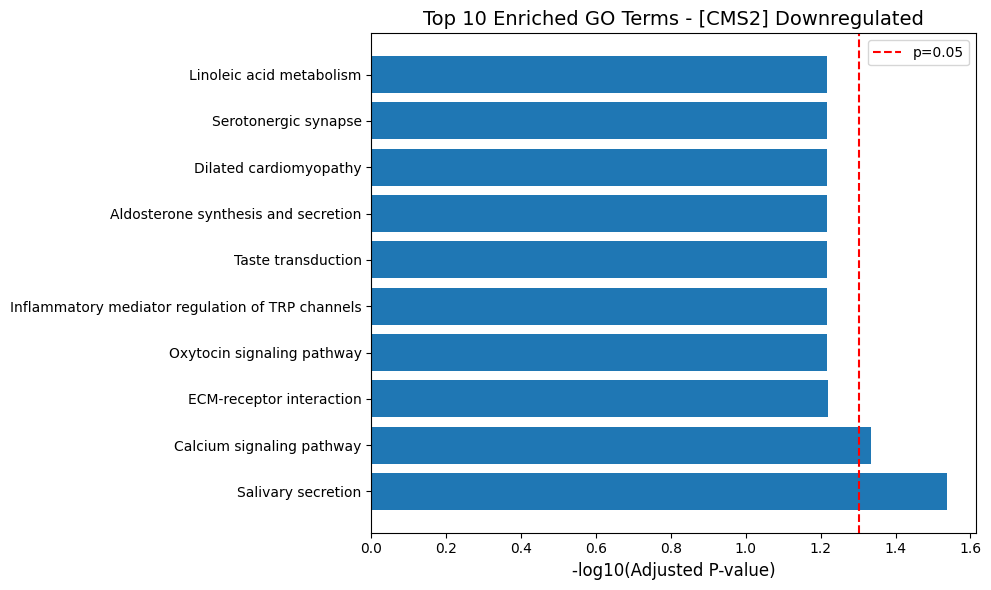

In [42]:
#bar plot
# Select top 10 terms by adjusted p-value
top_n = 10
top_terms = enr_down.results.head(top_n).copy()

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by adjusted p-value (ascending)
top_terms = top_terms.sort_values('Adjusted P-value', ascending=True)

# Create bars
y_pos = np.arange(len(top_terms))
bars = ax.barh(y_pos, -np.log10(top_terms['Adjusted P-value']))

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=10)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Top 10 Enriched GO Terms - [CMS2] Downregulated', fontsize=14)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
ax.legend()

plt.tight_layout()
plt.savefig('enrichment_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

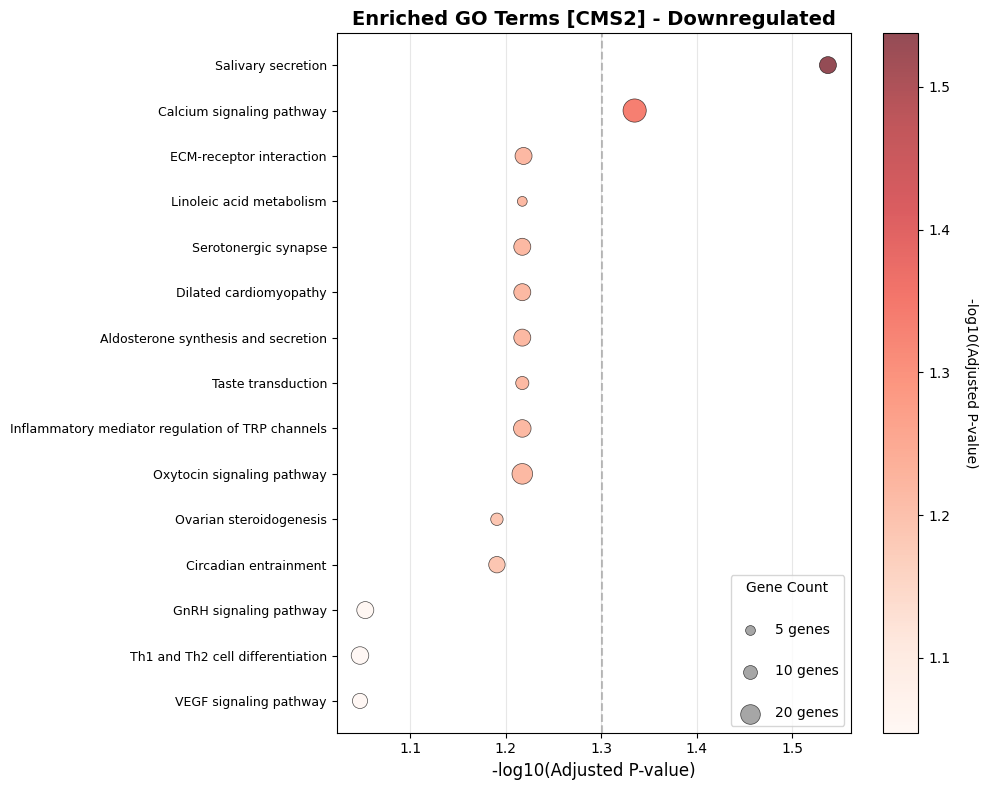

In [43]:
#dot plot
# Select top terms
top_n = 15
top_terms = enr_down.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create dot plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data
terms = top_terms['Term']
pvals = -np.log10(top_terms['Adjusted P-value'])
gene_counts = top_terms['Genes'].str.split(';').str.len()  # Count genes separated by semicolon

# Create scatter
scatter = ax.scatter(pvals, np.arange(len(terms)), 
                     s=gene_counts*10,  # Size by number of genes
                     c=pvals,  # Color by p-value
                     cmap='Reds', 
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Customize
ax.set_yticks(np.arange(len(terms)))
ax.set_yticklabels(terms, fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Enriched GO Terms [CMS2] - Downregulated', fontsize=14, fontweight='bold')
ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('-log10(Adjusted P-value)', rotation=270, labelpad=20)

# Add legend for size
sizes_to_show = [5, 10, 20]
for size in sizes_to_show:
    ax.scatter([], [], s=size*10, c='gray', alpha=0.7, 
               edgecolors='black', linewidth=0.5,
               label=f'{size} genes')
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, 
          title='Gene Count', loc='lower right')

plt.tight_layout()
plt.savefig('enrichment_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
from gseapy import barplot, dotplot

# Bar plot
barplot(enr_down.results, 
        title='GO Enrichment - [CMS2] Downregulated',
        cutoff=0.05,
        top_term=15,
        figsize=(8, 6),
        ofname='gseapy_barplot.png')

# Dot plot
dotplot(enr_down.results,
        title='GO Enrichment - [CMS3] Downregulated', 
        cutoff=0.05,
        top_term=15,
        figsize=(6, 8),
        ofname='gseapy_dotplot.png')

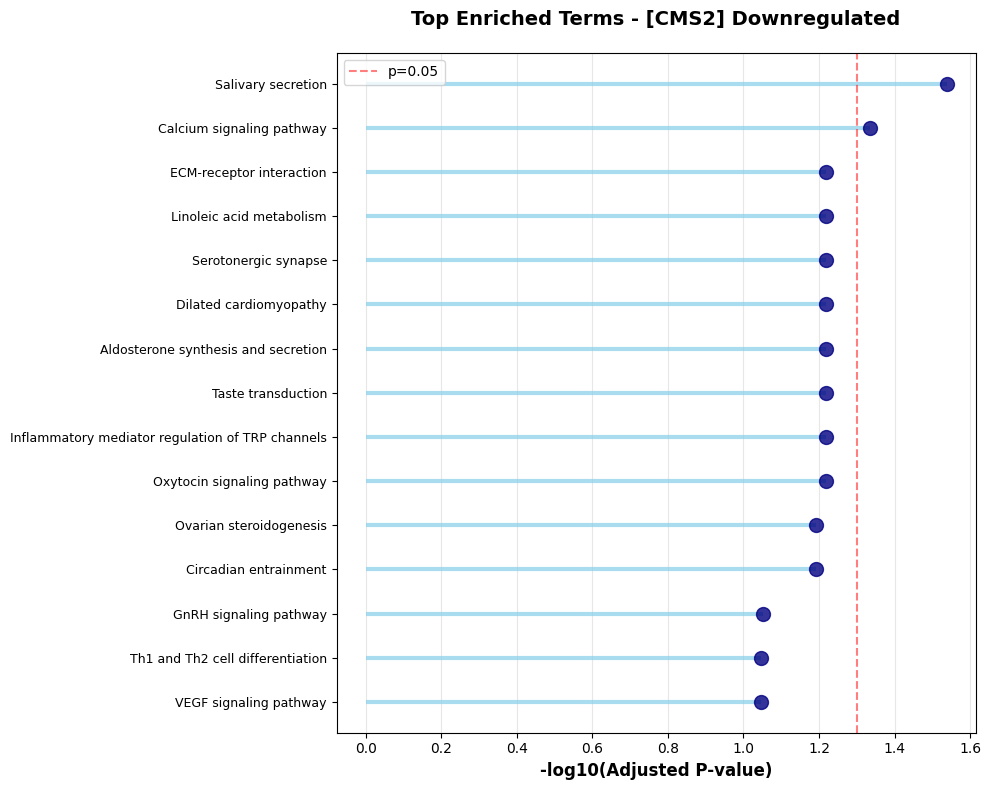

In [46]:
# Select top terms
top_n = 15
top_terms = enr_down.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Data
y_pos = np.arange(len(top_terms))
pvals = -np.log10(top_terms['Adjusted P-value'])

# Create lollipop
ax.hlines(y=y_pos, xmin=0, xmax=pvals, color='skyblue', alpha=0.7, linewidth=3)
ax.plot(pvals, y_pos, "o", markersize=10, color='navy', alpha=0.8)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12, fontweight='bold')
ax.set_title('Top Enriched Terms - [CMS2] Downregulated', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', 
           label='p=0.05', alpha=0.5)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('enrichment_lollipop.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
enr_down.results.to_csv('CMS2_Down_GO_enrichment.csv', index=False)

### upregulated

In [10]:
enr = gp.enrichr(gene_list= scvi_de[scvi_de['lfc_mean'] > 0].index.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2023'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )
enr

In [28]:
enr.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Fat digestion and absorption,0.000271,0.032744,0,0,27.743243,227.905693,FABP1;FABP2;PLA2G2A
1,KEGG_2021_Human,Oxidative phosphorylation,0.001636,0.082640,0,0,8.611170,55.242905,PPA1;NDUFB5;NDUFAB1;NDUFC2
2,KEGG_2021_Human,Retrograde endocannabinoid signaling,0.002049,0.082640,0,0,8.075131,49.988621,GNG4;NDUFB5;NDUFAB1;NDUFC2
3,KEGG_2021_Human,PPAR signaling pathway,0.003280,0.099231,0,0,10.968129,62.735495,FABP1;FABP2;FABP3
4,KEGG_2021_Human,Non-alcoholic fatty liver disease,0.006585,0.155695,0,0,5.743755,28.850802,CXCL8;NDUFB5;NDUFAB1;NDUFC2
...,...,...,...,...,...,...,...,...,...
727,GO_Biological_Process_2023,Protein Modification Process (GO:0036211),0.967298,0.973672,0,0,0.289348,0.009620,PTPRO
728,GO_Biological_Process_2023,Positive Regulation Of DNA-templated Transcrip...,0.977170,0.981992,0,0,0.345580,0.007981,GAL;SPP1
729,GO_Biological_Process_2023,Positive Regulation Of Transcription By RNA Po...,0.985331,0.988567,0,0,0.233095,0.003444,GAL
730,GO_Biological_Process_2023,Regulation Of DNA-templated Transcription (GO:...,0.999796,0.999842,0,0,0.112335,0.000023,SPP1


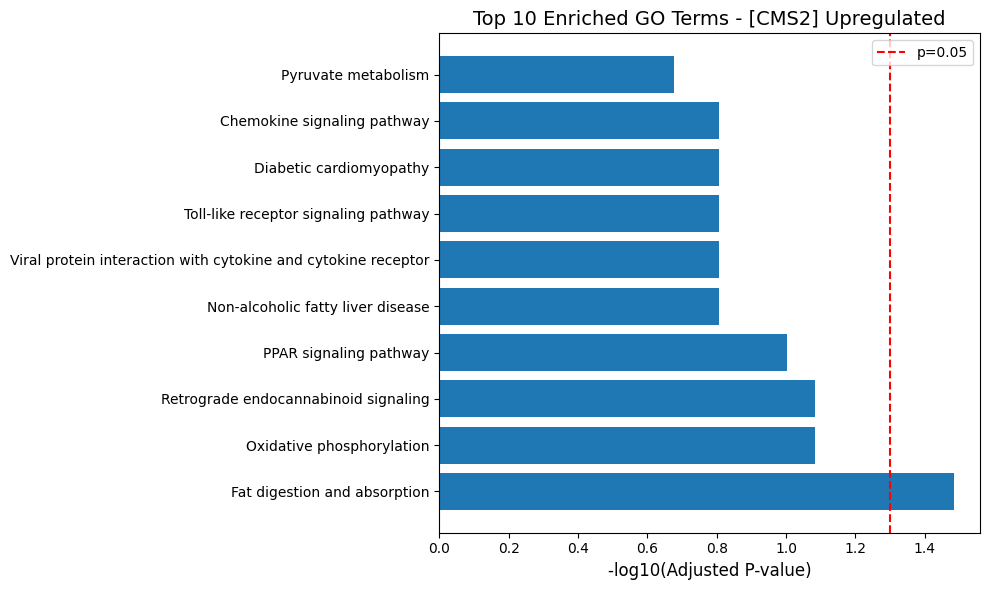

In [40]:
#bar plot
# Select top 10 terms by adjusted p-value
top_n = 10
top_terms = enr.results.head(top_n).copy()

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by adjusted p-value (ascending)
top_terms = top_terms.sort_values('Adjusted P-value', ascending=True)

# Create bars
y_pos = np.arange(len(top_terms))
bars = ax.barh(y_pos, -np.log10(top_terms['Adjusted P-value']))

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=10)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Top 10 Enriched GO Terms - [CMS2] Upregulated', fontsize=14)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
ax.legend()

plt.tight_layout()
plt.savefig('enrichment_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

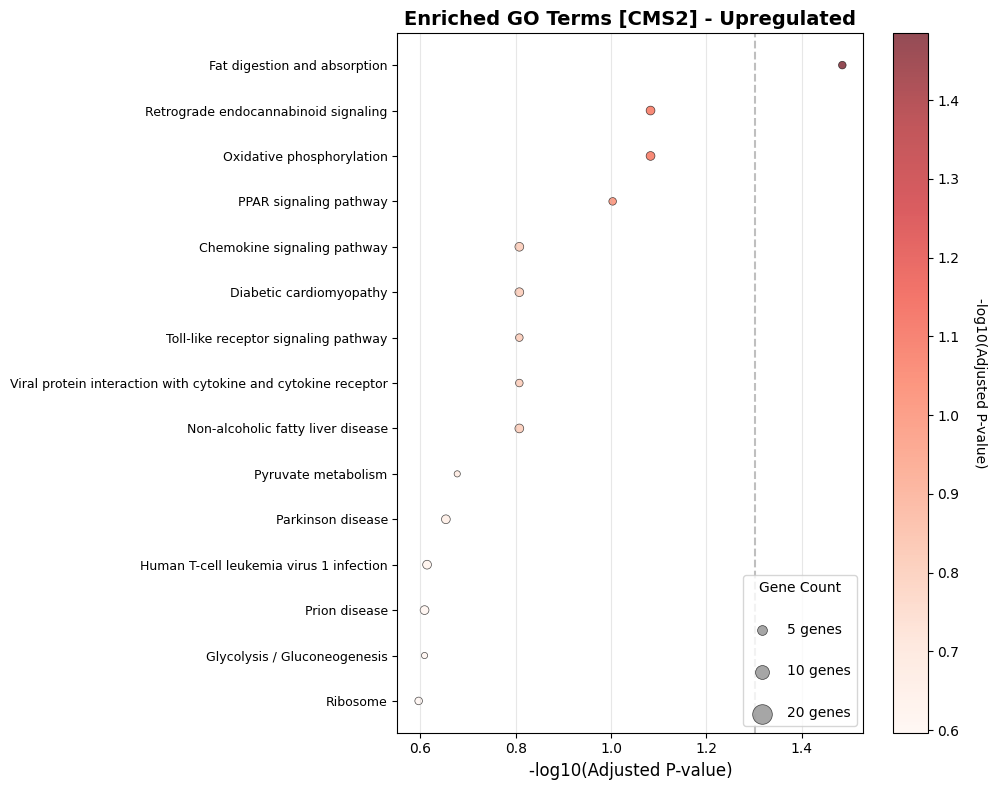

In [41]:
#dot plot
# Select top terms
top_n = 15
top_terms = enr.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create dot plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data
terms = top_terms['Term']
pvals = -np.log10(top_terms['Adjusted P-value'])
gene_counts = top_terms['Genes'].str.split(';').str.len()  # Count genes separated by semicolon

# Create scatter
scatter = ax.scatter(pvals, np.arange(len(terms)), 
                     s=gene_counts*10,  # Size by number of genes
                     c=pvals,  # Color by p-value
                     cmap='Reds', 
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Customize
ax.set_yticks(np.arange(len(terms)))
ax.set_yticklabels(terms, fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Enriched GO Terms [CMS2] - Upregulated', fontsize=14, fontweight='bold')
ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('-log10(Adjusted P-value)', rotation=270, labelpad=20)

# Add legend for size
sizes_to_show = [5, 10, 20]
for size in sizes_to_show:
    ax.scatter([], [], s=size*10, c='gray', alpha=0.7, 
               edgecolors='black', linewidth=0.5,
               label=f'{size} genes')
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, 
          title='Gene Count', loc='lower right')

plt.tight_layout()
plt.savefig('enrichment_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
from gseapy import barplot, dotplot

# Bar plot
barplot(enr.results, 
        title='GO Enrichment - [CMS2] Upregulated',
        cutoff=0.05,
        top_term=15,
        figsize=(8, 6),
        ofname='gseapy_barplot.png')

# Dot plot
dotplot(enr.results,
        title='GO Enrichment - [CMS3] Upregulated', 
        cutoff=0.05,
        top_term=15,
        figsize=(6, 8),
        ofname='gseapy_dotplot.png')

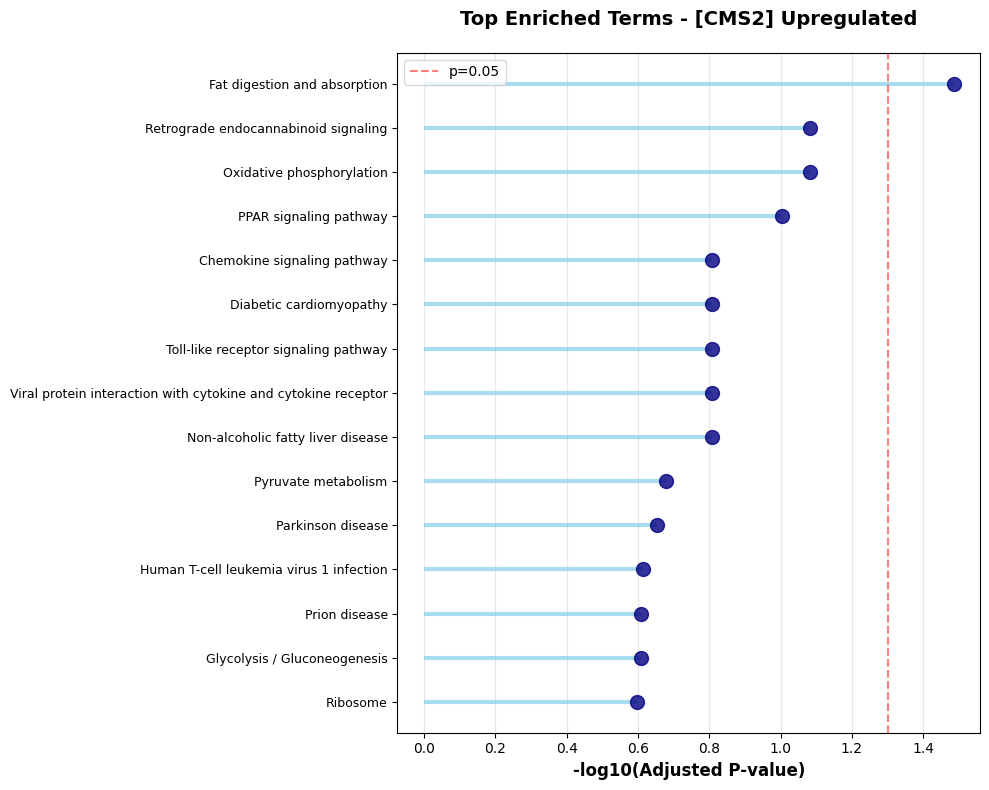

In [32]:
# Select top terms
top_n = 15
top_terms = enr.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Data
y_pos = np.arange(len(top_terms))
pvals = -np.log10(top_terms['Adjusted P-value'])

# Create lollipop
ax.hlines(y=y_pos, xmin=0, xmax=pvals, color='skyblue', alpha=0.7, linewidth=3)
ax.plot(pvals, y_pos, "o", markersize=10, color='navy', alpha=0.8)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12, fontweight='bold')
ax.set_title('Top Enriched Terms - [CMS2] Upregulated', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', 
           label='p=0.05', alpha=0.5)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('enrichment_lollipop.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
enr.results.to_csv('CMS2_Up_GO_enrichment.csv', index=False)